<a href="https://colab.research.google.com/github/mwl10/hetvae/blob/errors/src/catalina_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil#
os.chdir('/content')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
from glob import glob
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
import importlib
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 3992, done.
remote: Counting objects: 100% (1028/1028), done.
remote: Compressing objects: 100% (859/859), done.
remote: Total 3992 (delta 218), reused 265 (delta 169), pack-reused 2964
Receiving objects: 100% (3992/3992), 42.34 MiB | 12.82 MiB/s, done.
Resolving deltas: 100% (1163/1163), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 14.4 MB/s 
     |████████████████████████████████| 81 kB 10.8 MB/s 
     |████████████████████████████████| 149 kB 95.4 MB/s 
     |████████████████████████████████| 78 kB 4.5 MB/s 
     |████████████████████████████████| 15.7 MB 75.7 MB/s 
     |████████████████████████████████| 308 kB 93.2 MB/s 
     |████████████████████████████████| 112 kB 80.9 MB/s 
     |████████████████████████████████| 2.1 MB 55.8 MB/s 
     |████████████████████████████████| 596 kB 72.2 MB/s 
     |█████████████████████████

['/content/hetvae/data/CAT/CSS/CSS170320:110636+193253_20.34.dat', '/content/hetvae/data/CAT/CSS/CSS170925:235758-120558_18.32.dat', '/content/hetvae/data/CAT/CSS/CSS170321:125647+452323_19.55.dat', '/content/hetvae/data/CAT/CSS/CSS170928:220238+103029_18.65.dat', '/content/hetvae/data/CAT/CSS/CSS171011:010004-132449_19.01.dat', '/content/hetvae/data/CAT/CSS/CSS170318:140157+452716_19.29.dat', '/content/hetvae/data/CAT/CSS/CSS170131:135357-074301_19.9.dat', '/content/hetvae/data/CAT/CSS/CSS170323:083128+192242_19.0.dat', '/content/hetvae/data/CAT/CSS/CSS170924:000329+142215_19.13.dat', '/content/hetvae/data/CAT/CSS/CSS170930:072702+525141_18.55.dat', '/content/hetvae/data/CAT/CSS/CSS170626:144534+461748_20.55.dat', '/content/hetvae/data/CAT/CSS/CSS170202:100034+455823_19.25.dat', '/content/hetvae/data/CAT/CSS/CSS170929:001323+014545_20.2.dat', '/content/hetvae/data/CAT/CSS/CSS170628:132717+023457_20.81.dat', '/content/hetvae/data/CAT/CSS/CSS170202:013058+311446_18.92.dat', '/content/he

/content/hetvae/src/dataset.py:328: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:,2] = 1. / self.dataset[:,:,2]


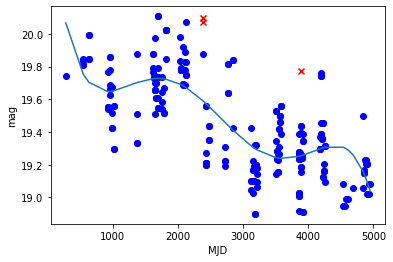

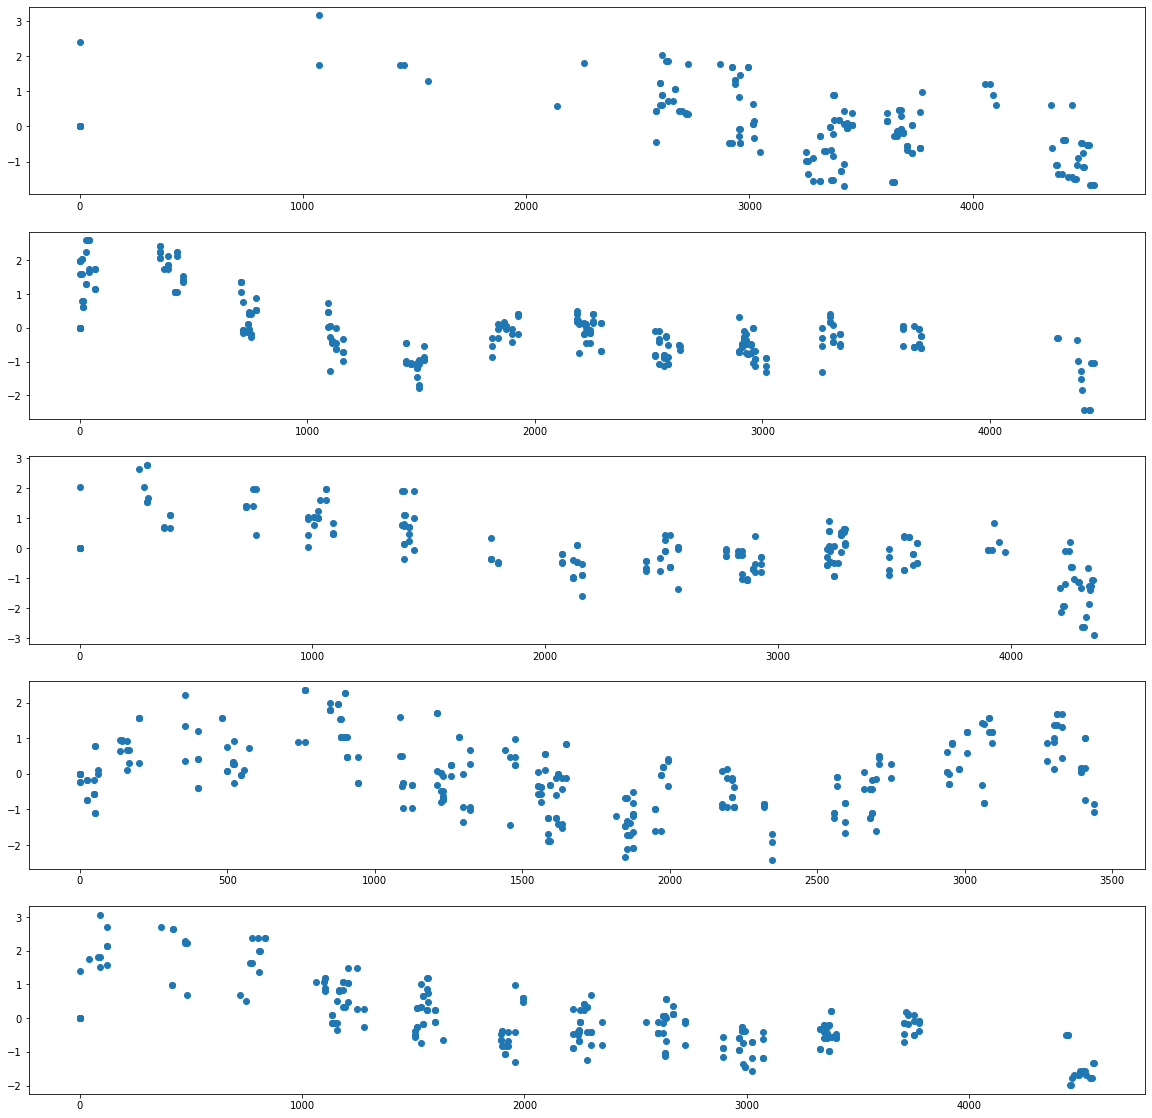

In [2]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Catalina data
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/CAT/*/*')[:50]
print(lc_files)
Catalina = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy(maximum=1000)
Catalina.dataset = [x[:300] for x in Catalina.dataset]
Catalina.handle_dups() \
            .prune_graham(plot=True, index=5, res_std=False) \
            .normalize(normalize_x='', normalize_y='individual', x_by_range=False) \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight() \


print(
    Catalina.files, '\n',
    Catalina.union_x.shape,
    Catalina.dataset.shape,
  )
fig,ax = plt.subplots(5,1, figsize=(20,20))
for i in range(5):
    ax[i].scatter(Catalina.dataset[i,:,0], Catalina.dataset[i,:,1])

In [30]:
# num heads?
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.3, 
                 elbo_weight=1, embed_time=128, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.001, mixing='concat_and_mix', mse_weight=9., net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, recon_loss=False, 
                 sample_tp=0.2, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=64)

DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
LightCurves = Catalina.dataset

In [32]:
training, valid = np.split(LightCurves, [int(np.floor(0.8*len(LightCurves)))])# shuffle?
train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
net = models.load_network(args, DIM, torch.Tensor(Catalina.union_x)) 
params = list(net.parameters())


In [33]:
optimizer = optim.Adam(params, lr=0.002057519)

In [34]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.00257519

0.002057519


In [35]:
for epoch in range(1, 1001): #args.niters + 1):
    nll, mse = my_utils.train(net, optimizer, epoch, train_loader, args, frac=0.2)
    

Iter: 100, train loss: 10.2189, avg nll: 1.4037, avg kl: 0.0214, mse: 0.979228, mae: 0.795821
Iter: 200, train loss: nan, avg nll: nan, avg kl: nan, mse: nan, mae: nan


KeyboardInterrupt: ignored

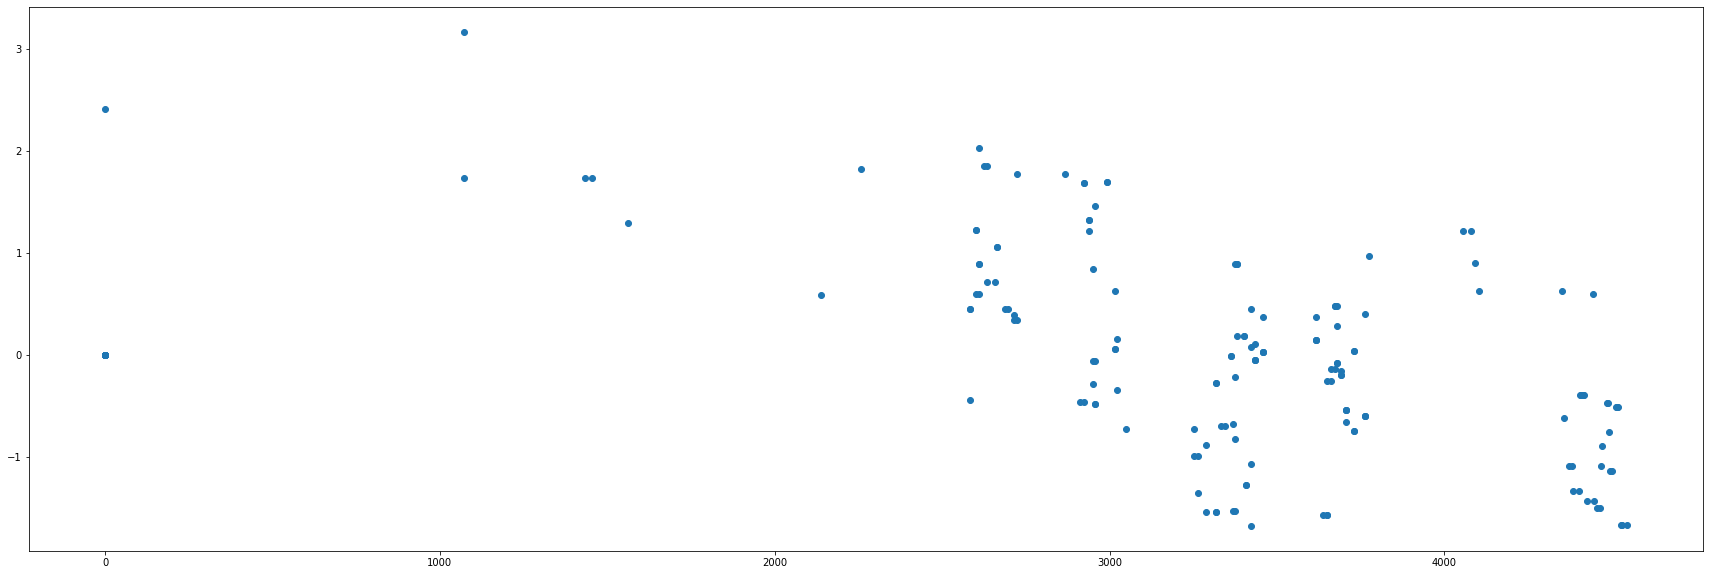

In [36]:
viz_per_example(Catalina.dataset[0], Catalina.target_x[0], net, num_points=200, device="cuda", k_iwae=10, frac=1)

In [21]:
# visualisation for one light curve w/ increasing number of points
def viz_per_example(example, target_x, net, num_points=40, device="cuda", k_iwae=10, frac=1): 
    example = example[np.newaxis, :,:]
    target_x = target_x[np.newaxis, :, np.newaxis]
    np.random.seed(0)
    with torch.no_grad(): 
        # if torch.is_tensor(example):
        #     example = example.cpu().numpy()
        example = torch.tensor(example)
        # make new masks relative to fraction of points we got to predict w/ 
        subsampled_mask, recon_mask = my_utils.make_masks(example, frac=frac)
        #example = np.concatenate((example, smask[:,:,np.newaxis], rmask[:,:,np.newaxis], target_x), axis=-1) # format the masks 
        example = torch.cat((example, torch.unsqueeze(subsampled_mask, 2), torch.unsqueeze(recon_mask, 2), torch.tensor(target_x)), axis=-1)

        #example = torch.tensor(example)
        example = example.to(device)
        
        subsampled_mask = example[:,:,3:4]
        context_y = torch.cat((example[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
        px, qz = net.get_reconstruction(example[:,:, 0], context_y, example[:,:,5], num_samples=k_iwae)

        qz_mean = (qz.mean.cpu().numpy())
        qz_std = (torch.exp(0.5 * qz.logvar).cpu().numpy())
        px_mean = px.mean.cpu().numpy()
        px_std = torch.exp(0.5 * px.logvar).cpu().numpy()
        example = example.cpu().numpy()

        px_mean = np.mean(px_mean, axis=0)[0,:num_points,0]
        px_std = np.mean(px_std, axis=0)[0,:num_points,0]
        target_x = target_x[0,:num_points,0]
        w=2.0
        plt.figure(figsize=(30, 10))
        plt.fill_between(target_x, px_mean - 2*px_std, px_mean+2*px_std, color='gray')

        plt.plot(target_x, px_mean, c='b', lw=w, label='Reconstructions', zorder=20)
        plt.scatter(example[0,:,0], example[0,:,1])
        plt.errorbar(target_x, px_mean ,yerr=px_std,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')

        plt.show()
        reconstruction = np.concatenate((target_x[:,np.newaxis], px_mean[:,np.newaxis], px_std[:,np.newaxis]), axis=1)
        #print(f'qz shape: {qz_mean.shape}')
        #print(f'reconstructed example: {reconstruction.shape}')
        #return reconstruction, qz_mean,qz_std